[Will ClinVar change my data?](https://www.ncbi.nlm.nih.gov/clinvar/docs/submit/#change)
> In general, ClinVar does not change data that was submitted to the database. There are a few scenarios in which we change the format, but not the content, of data during submission processing:
>    * remove spaces from HGVS expressions, unless the space is between integers
>    * convert HPO: to HP: and report as HP:0000000 for an HPO identifiers
>    * modify Location in gene information according to ClinVar's conventions, including extra spaces, capitalization, abbreviations, and unsupported terms for Location in gene

Via [full submission spreadsheet](https://www.ncbi.nlm.nih.gov/clinvar/docs/submit/#spreadsheet): For conditions, either an identifier or preferred condition name (free text) is required, and the latter only if not present in supported ontologies.  It must be one or the other but _not both_ ("Providing both will result in an error").
Identifiers must be from OMIM, MeSH, Orphanet, MedGen, HPO, Mondo, UMLS (anything else must "check with us first").

From the [original paper](https://academic.oup.com/nar/article/42/D1/D980/1051029?login=true):
> Submitters are encouraged to submit phenotypic information via identifier, e.g. MIM number, MeSH term, or identifier from the Human Phenotype Ontology (HPO) (10). Free text is accepted, however, and ClinVar staff will work with submitters to determine if that text can be mapped to standardized concepts. When such mapping is possible, ClinVar connects the phenotype to a concept in MedGen (11) and adds MedGen’s identifier to the RCV record

And a bit more on data augmentation - in particular functional/molecular consequences, genes and location info:
> Some of the data ClinVar reports related to variation are added by NCBI. These data are reported only as part of the aggregate record (accession starting with RCV), and can include alternate HGVS expressions, allele frequencies from the 1000 Genomes project (7) or GO-ESP (8), identifiers from dbSNP or dbVar, molecular consequences (e.g. nonsense/missense/frameshift) and location data (splice site, untranslated regions, cytogenetic band, gene symbols and names). Values for molecular consequence, type of variation and location relative to a gene are standardized by reference to identifiers from the Sequence Ontology (9).

## Ontology mappings

* What ontology mappings are already in ClinVar?
* Are these directly from the submitters or annotated by ClinVar?
* How often are they present?
* How does the quality and coverage of the mappings compare with our mappings?

In [5]:
import sys

sys.path.append('..')

In [6]:
from collections import Counter
import csv

from filter_clinvar_xml import filter_xml, pprint, iterate_cvs_from_xml
from clinvar_xml_io.clinvar_xml_io import *

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

In [7]:
# January 2023
clinvar_xml = '/home/april/projects/opentargets/clinvar.xml.gz'

In [8]:
clinvar = ClinVarDataset(clinvar_xml)

In [35]:
# Distribution of ontologies among RCVs and traits
ontology_counts_per_rcv = Counter()
ontology_counts_per_trait = Counter()
num_rcvs = 0
num_traits = 0
for record in clinvar:
    num_rcvs += 1
    dbs_in_rcv = set()
    for trait in record.traits:
        num_traits += 1
        has_db = False
        # list of (db, id, status)
        for db, _, _ in trait.xrefs:
            dbs_in_rcv.add(db)
            ontology_counts_per_trait[db] += 1
            has_db = True
        if not has_db:
            ontology_counts_per_trait['none'] += 1
    for db in dbs_in_rcv:
        ontology_counts_per_rcv[db] += 1
    if not dbs_in_rcv:
        ontology_counts_per_rcv['none'] += 1

In [36]:
num_rcvs

2302323

In [37]:
num_traits

2553551

In [106]:
ontology_keys = ['EFO', 'MONDO', 'Orphanet', 'OMIM', 'HPO', 'MedGen', 'Gene', 'MeSH', 'none']

In [107]:
def get_values(counter, keys=ontology_keys):
    values = []
    for k in keys:
        if k == 'HPO' and 'Human Phenotype Ontology' in counter:
            values.append(counter['Human Phenotype Ontology'])
        elif k in counter:
            values.append(counter[k])
        else:
            values.append(0)
    return values

In [108]:
def print_counter(counter, keys=ontology_keys):
    for k, v in zip(keys, get_values(counter, keys)):
        print(f'{k: <8} {v}')

In [144]:
def plot_counter(counter, title, keys=ontology_keys):
    plt.figure(figsize=(15,10))
    plt.title(title)
    bars = plt.bar(keys, get_values(counter, keys))
    plt.bar_label(bars, padding=3)

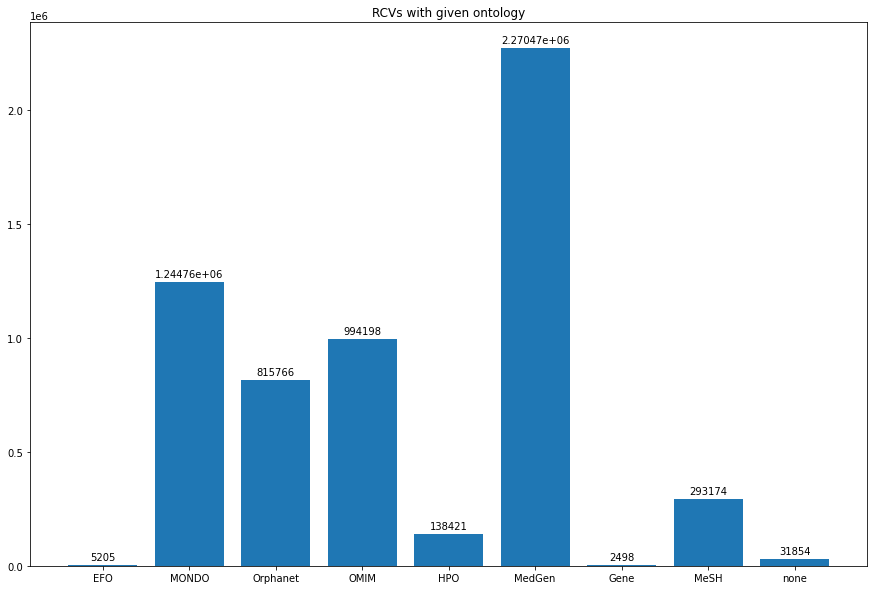

In [145]:
plot_counter(ontology_counts_per_rcv, 'RCVs with given ontology')

In [97]:
print_counter(ontology_counts_per_rcv)

EFO      5205
MONDO    1244756
Orphanet 815766
OMIM     994198
HPO      138421
MedGen   2270469
Gene     2498
MeSH     293174
none     31854


In [ ]:
plot_counter(ontology_counts_per_trait, 'Traits with given ontology')

In [99]:
print_counter(ontology_counts_per_trait)

EFO      5219
MONDO    1472295
Orphanet 1045481
OMIM     1225769
HPO      377503
MedGen   2520361
Gene     2498
MeSH     293927
none     33190


In [39]:
# from metrics
metrics_num_rcvs = 2302323  # obviously same as count direct from XML
metrics_missing_efo = 23180
metrics_missing_conseq = 20598

In [40]:
# ClinVar RCV max coverage of a single ontology (medgen)
ontology_counts_per_rcv['MedGen'] / metrics_num_rcvs

0.9861644087297916

In [41]:
# ClinVar coverage of MONDO
ontology_counts_per_rcv['MONDO'] / metrics_num_rcvs

0.5406522021453983

In [43]:
# ClinVar coverage of EFO
ontology_counts_per_rcv['EFO'] / metrics_num_rcvs

0.002260760110549215

In [42]:
# Our coverage of EFO
(metrics_num_rcvs - metrics_missing_efo) / metrics_num_rcvs

0.9899319079034523

#### Notes from our processing

* ClinVar cross-refs are _only_ used for Zooma feedback, not elsewhere and in particular not in manual curation
    * this seems kind of ridiculous to me?
    * even the cross refs for EFO import are from OxO and not Clinvar
* MedGen ids are reported as disease source id in evidence string but not otherwise used
    * see [#207](https://github.com/EBIvariation/eva-opentargets/issues/207)
    
#### Other notes

MedGen - not an ontology but a "list of terms", hence not really supported by SPOT tools (though compare OMIM which is also described as a database, but is supported by OxO though not OLS)

Ask OT why they chose EFO - can form part of our justification as well (in addition to being a kind of domain transfer exercise)

Mappings in ClinVar might be out of date as they depend on submitters to update data (though also our mappings can fall out of date)

Cross-refs from Clinvar do make it into Zooma via our feedback, kind of roundabout but also allows them to be leveraged by the larger community (?)

Given the submission instructions, assume that the trait names are actually annotated by ClinVar from the ontologies (probably explains the number of exact matches)

#### Comparing distribution among terms with mappings vs without

In [45]:
# January 2023
efo_mappings = '/home/april/projects/opentargets/trait_names_to_ontology_mappings.tsv'

In [51]:
our_mappings = {}
with open(efo_mappings) as f:
    reader = csv.reader(f, delimiter='\t')
    for row in reader:
        clinvar_label, uri, label = row
        our_mappings[clinvar_label.lower().strip()] = uri

In [52]:
ontology_counts_with_mapping = Counter()
ontology_counts_without_mapping = Counter()

for record in clinvar:
    dbs_in_rcv = set()
    with_mapping = False
    for trait in record.traits:
        # list of (db, id, status)
        for db, _, _ in trait.xrefs:
            dbs_in_rcv.add(db)
        # check for any trait name in mappings
        for name in trait.all_names:
            if name.lower().strip() in our_mappings:
                with_mapping = True
                
    for db in dbs_in_rcv:
        if with_mapping:
            ontology_counts_with_mapping[db] += 1
        else:
            ontology_counts_without_mapping[db] += 1
    if not dbs_in_rcv:
        if with_mapping:
            ontology_counts_with_mapping['none'] += 1
        else:
            ontology_counts_without_mapping['none'] += 1

In [146]:
def plot_stacked_counters(with_mapping, without_mapping, title, keys=ontology_keys):
    fig, ax = plt.subplots(figsize=(15,10))
    with_values = get_values(with_mapping, keys)
    without_values = get_values(without_mapping, keys)
    with_bars = ax.bar(keys, with_values, label='With mappings')
    without_bars = ax.bar(keys, without_values, bottom=with_values, label='Without mappings')
    ax.bar_label(without_bars, labels=zip(with_values, without_values), padding=3)
    ax.set_title(title)
    ax.legend()

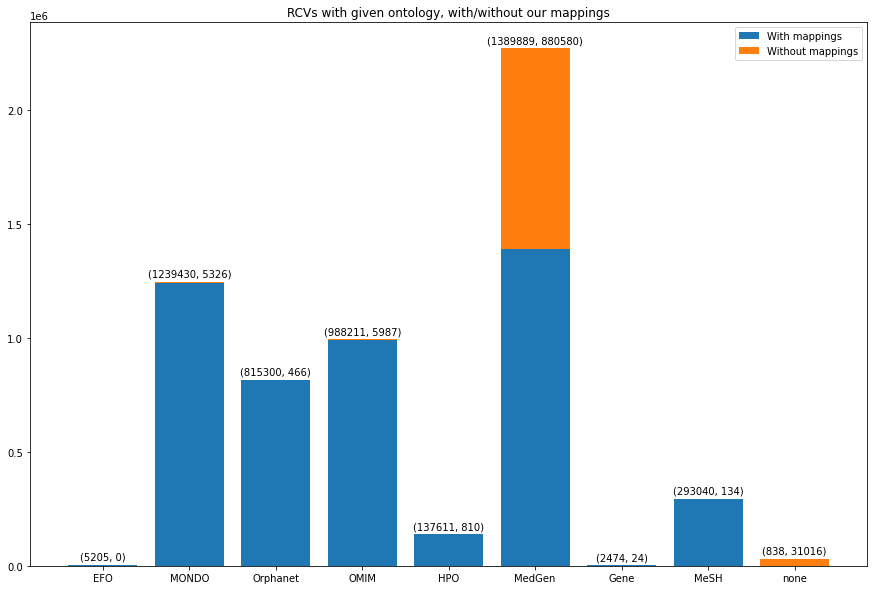

In [148]:
plot_stacked_counters(ontology_counts_with_mapping, ontology_counts_without_mapping, 'RCVs with given ontology, with/without our mappings')

In [101]:
print_counter(ontology_counts_with_mapping)

EFO      5205
MONDO    1239430
Orphanet 815300
OMIM     988211
HPO      137611
MedGen   1389889
Gene     2474
MeSH     293040
none     838


In [103]:
print_counter(ontology_counts_without_mapping)

EFO      0
MONDO    5326
Orphanet 466
OMIM     5987
HPO      810
MedGen   880580
Gene     24
MeSH     134
none     31016


In [149]:
sum(ontology_counts_without_mapping.values())

924343

In [ ]:
plot_counter(ontology_counts_with_mapping, 'RCVs with given ontology (mapped by us)')

In [ ]:
plot_counter(ontology_counts_without_mapping, 'RCVs with given ontology (not mapped by us)')

In [105]:
# Percentage of ClinVar records not covered by EFO or an importable term (HP, ORDO / Orphanet, MONDO)
importable_ontologies = {'Human Phenotype Ontology', 'EFO', 'Orphanet', 'MONDO'}
importable_ontology_counts = Counter()
importable_with_mapping = Counter()
importable_without_mapping = Counter()

for record in clinvar:
    importable = False
    with_mapping = False
    for trait in record.traits:
        # list of (db, id, status)
        for db, _, _ in trait.xrefs:
            if db in importable_ontologies:
                importable = True
                break
        # check for any trait name in mappings
        for name in trait.all_names:
            if name.lower().strip() in our_mappings:
                with_mapping = True
                break
    if importable:
        importable_ontology_counts['importable'] += 1
        if with_mapping:
            importable_with_mapping['importable'] += 1
        else:
            importable_without_mapping['importable'] += 1
    else:
        importable_ontology_counts['none'] += 1
        if with_mapping:
            importable_with_mapping['none'] += 1
        else:
            importable_without_mapping['none'] += 1

In [135]:
importable_ontology_counts

Counter({'importable': 1266670, 'none': 1035653})

In [150]:
importable_ontology_counts['importable'] / num_rcvs

0.5501704148375358

In [122]:
importable_with_mapping

Counter({'importable': 1260649, 'none': 130078})

In [123]:
importable_without_mapping

Counter({'importable': 6021, 'none': 905575})

In [ ]:
plot_stacked_counters(importable_with_mapping, importable_without_mapping, 'importable', ('importable', 'none'))

### Summary for ontologies

* ClinVar uses and actually prefers identifiers for traits from submissions
    * The vast majority are MedGen: 98.6% of RCVs have an associated MedGen ID
    * The text we are curating is probably from MedGen, only a small amount is text from submitters
    * However only 55% of RCVs are associated with a term from EFO or an importable ontology
* We've covered about 99.0% of RCVs via our EFO mappings
    * Most terms we've not yet mapped to EFO are associated with MedGen ids (or none)
    * We don't currently use ClinVar ontology xrefs in curation directly, only indirectly via feedback to Zooma
* Next steps
    * Check whether mappings contained in ClinVar are up-to-date
    * Ask OT why they chose EFO
        * example of why one might want ClinVar data mapped to different ontologies
    * Resurrect [#207](https://github.com/EBIvariation/eva-opentargets/issues/207)
        * make better use of MedGen and xrefs in general

In [225]:
"""
Check whether ClinVar/EVA terms are obsolete - ran on the cluster as a standalone script
"""
# import argparse
# from collections import Counter
# import csv
# import multiprocessing
# import requests

# from eva_cttv_pipeline.trait_mapping.oxo import OntologyUri
# from eva_cttv_pipeline.clinvar_xml_io.clinvar_xml_io import *


# CURRENT = 'current'
# OBSOLETE = 'obsolete'
# CLINVAR = 'clinvar'
# EVA = 'eva'

# importable_ontologies = {'Human Phenotype Ontology', 'EFO', 'Orphanet', 'MONDO'}


# def get_our_mappings(mappings_file):
#     our_mappings = {}
#     with open(mappings_file) as f:
#         reader = csv.reader(f, delimiter='\t')
#         for row in reader:
#             clinvar_label, uri, label = row
#             our_mappings[clinvar_label.lower().strip()] = uri
#     return our_mappings


# def is_current(*, iri=None, db=None, iden=None):
#     term = iri
#     if not iri:
#         if iden.startswith('MONDO:'):
#             iden = iden[len('MONDO:'):]
#         if db.lower() == 'human phenotype ontology':
#             db = 'hp'
#             iden = iden[len('HP:'):]
#         term = str(OntologyUri(iden, db.lower()))
#     url = f'http://www.ebi.ac.uk/ols/api/terms?iri={term}'
#     response = requests.get(url)
#     response.raise_for_status()
#     try:
#         data = response.json()['_embedded']['terms'][0]
#         return (not data['is_obsolete'])#, data['term_replaced_by'])
#     except Exception as e:
#         print('Not found', iri, db, iden, url)
#         return False


# def process_record(record, our_mappings):
#     result = {}
#     # Collect mapped terms
#     all_clinvar_terms = set()
#     all_eva_terms = set()
#     for trait in record.traits:
#         for db, term_id, status in trait.xrefs:
#             if db in importable_ontologies and status == 'current':
#                 all_clinvar_terms.add((db, term_id))
#         for name in trait.all_names:
#             if name.lower().strip() in our_mappings:
#                 all_eva_terms.add(our_mappings[name.lower().strip()])
                
#     # For this record, see if *any* clinvar terms and *any* eva terms are found in ols & not obsolete
#     # If so we count as "current"
#     if any(is_current(db=db, iden=iden) for db, iden in all_clinvar_terms):
#         result[CLINVAR] = CURRENT
#     else:
#         result[CLINVAR] = OBSOLETE
#     if any(is_current(iri=iri) for iri in all_eva_terms):
#         result[EVA] = CURRENT
#     else:
#         result[EVA] = OBSOLETE
#     return result


# def print_counter(counter):
#     l = len(max(counter.keys(), key=lambda x: len(x)))
#     for k, v in counter.items():
#         print(f'{k: <{l}} {v}')


# def main(clinvar_xml, mappings_file):
#     our_mappings = get_our_mappings(mappings_file)
#     clinvar = ClinVarDataset(clinvar_xml)
#     process_pool = multiprocessing.Pool(processes=24)
#     output = [
#         process_pool.apply(process_record, args=(record, our_mappings))
#         for record in clinvar
#     ]
#     eva_counts = Counter([result[EVA] for result in output])
#     clinvar_counts = Counter([result[CLINVAR] for result in output])
#     print('EVA COUNTS')
#     print_counter(eva_counts)
#     print('CLINVAR COUNTS')
#     print_counter(clinvar_counts)


# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()
#     parser.add_argument('--clinvar-xml', required=True)
#     parser.add_argument('--mappings', required=True)
#     args = parser.parse_args()

#     main(args.clinvar_xml, args.mappings)